# Group Map

## Theory

Illustrate the use of `groupmap`, that defines a `GroupMap` module, to apply an optimal transportation map over a multidimensional input. The objective is to transform the input to follow a prescribed arbitrary distribution, like uniform, Gaussian, sparse, etc. 

> The main difference between `GroupMap` and normalization modules like `InstanceNorm`, `LayerNorm` or `GroupNorm` is it enforces the output to match _a whole distribution_ instead of just mean and variance.
> :warning: In this simplified implementation, there is no tracking of the input statistics and the module always uses the batch statistics for mapping, both at training and test time. 


Let $x$ be the input tensor, of arbitrary shape `(B, C, ...)` and let $x_{nc\boldsymbol{f}}$ be one of its entries for sample $n$, channel $c$ and a tuple of indices $\boldsymbol{f}$ corresponding to features. For instance, for images, we would have 2D features $\boldsymbol{f}=(i,j)$ for the row and column of a pixel. 

For each element of the input tensor, the following transformation is applied:

$y_{nc\boldsymbol{f}}=\mathit{Q}\left(\mathcal{F}_{nc}\left(x_{nc\boldsymbol{f}}\right)\right)$

Where:  
* $\forall q\in[0, 1],~\mathit{Q}(q)\in\mathbb{R}$ is the target _quantile function_. It describes what the distribution of the output should be and is provided by the user. The `GroupMap` module guarantees that the output will have a distribution that matches this target.

    > The `groupmap` module provides classical choices for this, including `groupmap.uniform`, `groupmap.gaussian`, `groupmap.sparse` and `groupmap.cauchy`.
    
    $\mathit{Q}(0)$ is the minimum of the target distribution, $\mathit{Q}(0.5)$ its median, $\mathit{Q}(1)$ its maximum, etc.
* $\mathcal{F}_{nc}(v)=\mathbb{P}(x_{nc,\boldsymbol{f}}\leq v)\in[0, 1]$  is the input cumulative distribution function (cdf) for sample $n$ and channel $c$.
   It is estimated on data for sample $n$. Several behaviours are possible, depending on which part of $x_n$ it is computed from.
   * It can be the cdf for just a particular channel $x_{nc}$, then behaving like some optimal-transport version of `InstanceNorm`.
   * It can be computed and shared over all channels of sample $x_n$  (as in `LayerNorm`)
   * It can be computed and shared over groups of channels (as in `GroupNorm`).
    > $\mathcal{F}_{nc}(v)=0$ if $v$ is the minimum of the input distribution, $0.5$ for the median, $1$ for the maximum, etc.).  


This formula corresponds to the classical _increasing rearrangement_ method to optimally transport scalar input data distributed wrt a distribution to another scalar distribution, by mapping quantile to quantile (min to min, median to median, max to max, etc.)  

## Example: transport a small tensor

In [9]:
# import
import torch
from torch import nn
from groupmap import GroupMap
import groupmap


Initialize a small `(3, 4)` tensor randomly and transport it with a uniform target, with different numbers of groups

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = torch.randn(1, 4, 4).to(device)
print('original data')
print(v[0].cpu().numpy())

# groupmap with each row as a group (as in instancenorm)
gm = GroupMap(
    num_groups=4,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with each row as a group')
print(gm(v)[0].cpu().numpy())

# groupmap with all rows together (as in layernorm)
gm = GroupMap(
    num_groups=1,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with all rows together as a group')
print(gm(v)[0].cpu().numpy())

# groupmap with groups of 2 consecutive rows (as in groupnorm)
gm = GroupMap(
    num_groups=2,
    num_channels=4,
    target_quantiles=groupmap.uniform
).to(device)
print('\ngroupmap with 2 groups (two consecutive rows together)')
print(gm(v)[0].cpu().numpy())

original data
[[ 2.2675493  -0.5355932  -0.9594439  -0.526434  ]
 [-0.56300575  0.45603803 -0.23818    -0.2557832 ]
 [-0.8675442  -0.9519985  -1.6582233  -0.3447896 ]
 [-2.7685483   1.2761954   1.6266245  -1.3452631 ]]

groupmap with each row as a group
[[1.         0.33333334 0.         0.6666666 ]
 [0.         1.         0.6666666  0.33333334]
 [0.6666666  0.33333334 0.         1.        ]
 [0.         0.6666666  1.         0.33333334]]

groupmap with all rows together as a group
[[1.         0.4666667  0.20000002 0.5333333 ]
 [0.40000004 0.8        0.73333335 0.6666666 ]
 [0.33333334 0.26666668 0.06666667 0.59999996]
 [0.         0.8666667  0.93333334 0.13333334]]

groupmap with 2 groups (two consecutive rows together)
[[1.         0.2857143  0.         0.42857146]
 [0.14285715 0.85714287 0.71428573 0.57142854]
 [0.57142854 0.42857146 0.14285715 0.71428573]
 [0.         0.85714287 1.         0.2857143 ]]


As can be seen, the minimum value for each group gets `0`, the max gets `1`, and in-between get the appropriate quantile value.

## Example: for image processing

### Data loading

In [11]:
# DATA
available_datasets = {'celeba', 'cifar10', 'mnist'}
dataset = 'celeba'
batchsize = 16

from torchvision.datasets import CelebA, CIFAR10, MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

if dataset=='celeba':
    dataset = CelebA(root='/data', split='train', download=True, transform=trans)
elif dataset=='cifar10':
    dataset = CIFAR10(root='/data', train=True, download=True, transform=trans)
elif dataset=='mnist':
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))])
    dataset = MNIST(root='/data', train=True, download=True, transform=trans)
    
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified


### Create groupmap and normalization modules

Now create a `GroupMap` and different normalization modules. Allocating many of them to see if that scales to deep architectures

In [12]:
num_groups = 1
num_channels=dataset[0][0].shape[0]

# creating a groupmap cascade
gm = GroupMap(
            num_groups = num_groups,
            num_channels = num_channels,
            target_quantiles = groupmap.uniform,
).to(device)

# creating a groupnorm cascade
gn = nn.GroupNorm(
            num_groups = num_groups,
            num_channels = num_channels
).to(device) 

# creating a layernorm cascade
ln = nn.LayerNorm(
            normalized_shape=dataset[0][0].shape[1:],
            elementwise_affine = False
).to(device)

# creating an instancenorm cascade
inn = nn.InstanceNorm2d(
            num_features=num_channels
).to(device) 


### Display statistics

Create an utilitary function to plot statistics of groups

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from einops import rearrange

def plot_statistics(v, num_groups, num_samples=4, title=None):
    v = v[:num_samples]
    batchsize, num_channels = v.shape[:2]
    v = v.view(batchsize, num_channels, -1)
    v = rearrange(v,'b (g p) f -> b g (p f)', g=num_groups)
    fig = plt.figure(figsize=(20,3))
    gs = fig.add_gridspec(num_groups, batchsize, hspace=0, wspace=0.2)
    axes = gs.subplots()
    for g, n in product(range(num_groups), range(batchsize)):
        if num_groups==1:
            ax = axes[n]
        else:
            ax = axes[g][n]
        sns.histplot(data=v[n,g,:].cpu().numpy(), ax=ax, bins=100)
        if not g:
            ax.set_title(f'sample {n+1}')
    if title:
        plt.suptitle(title)
    #plt.tight_layout()
    plt.show()

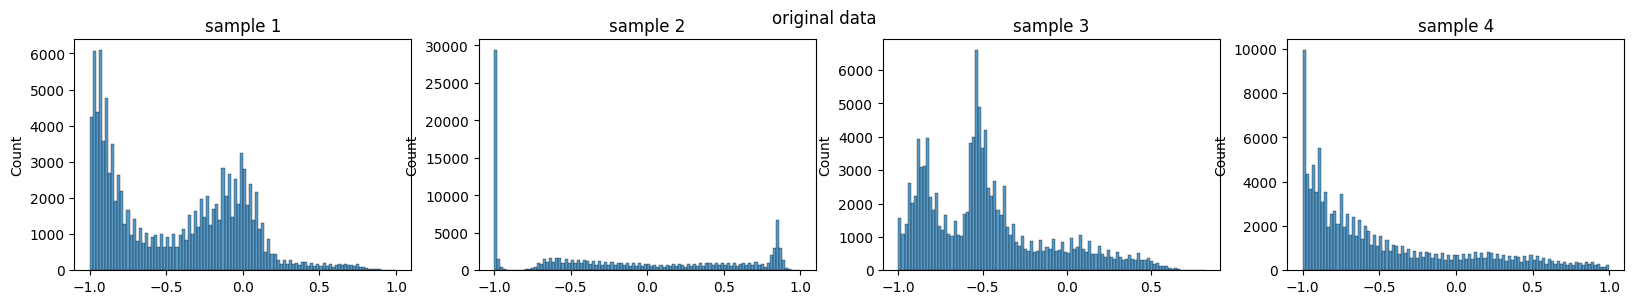

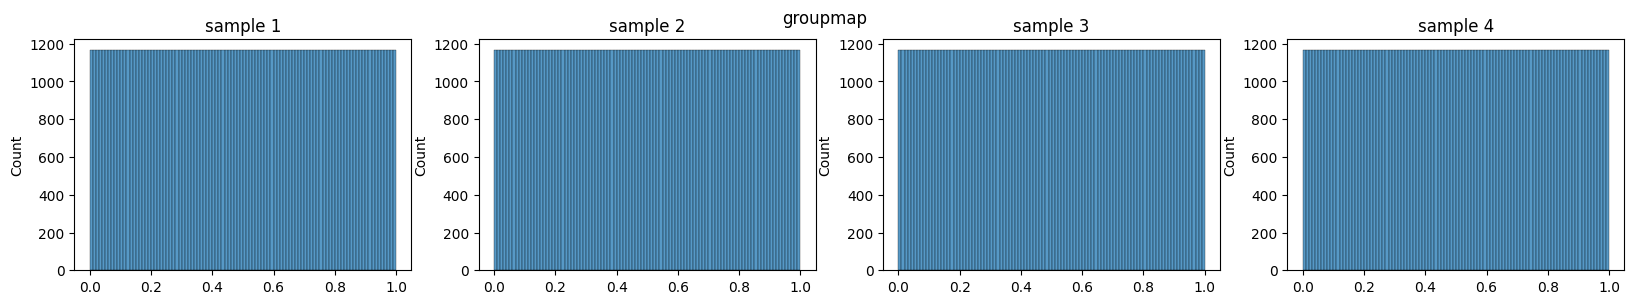

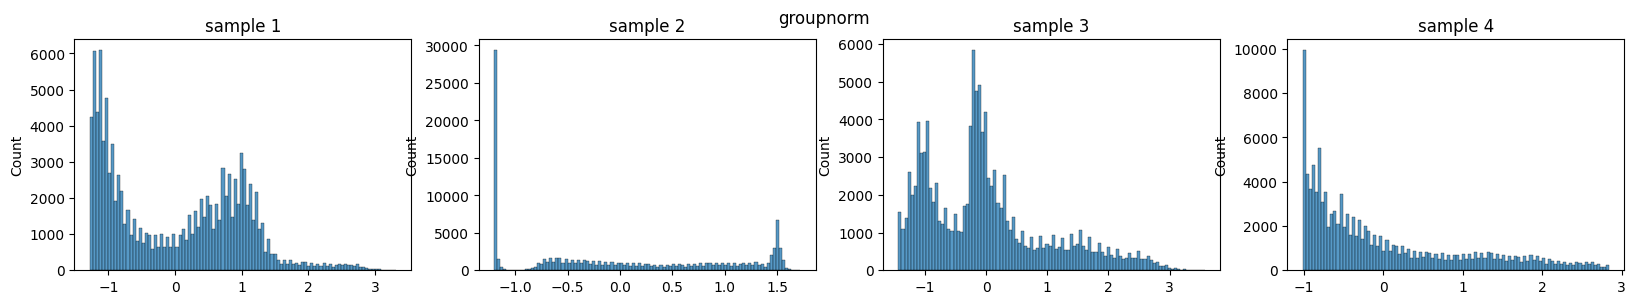

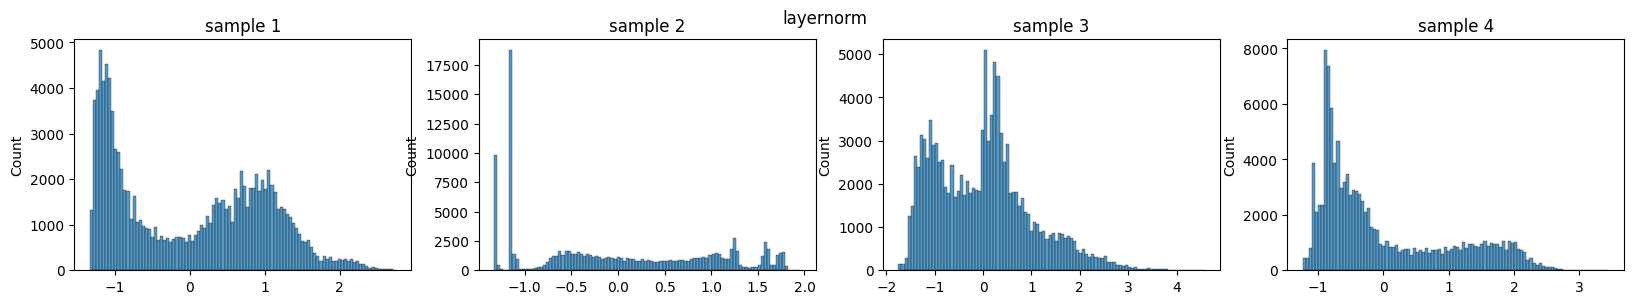

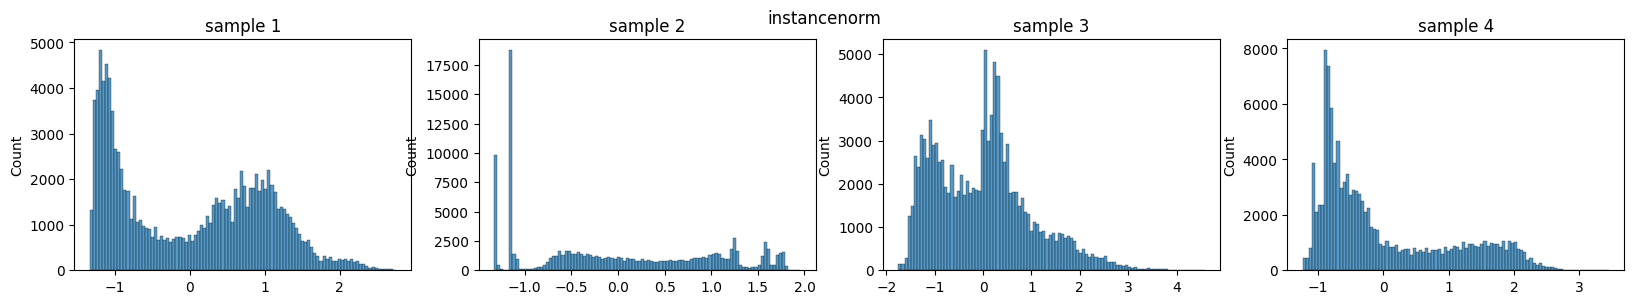

In [6]:
# plot the statistics of the first 4 samples of a batch

x = next(iter(dataloader))[0].to(device)
plot_statistics(x.detach().cpu(), num_groups,num_samples=4, title='original data'); 
plot_statistics(gm(x).detach().cpu(), num_groups,num_samples=4, title='groupmap'); 
plot_statistics(gn(x).detach().cpu(), num_groups,num_samples=4, title='groupnorm'); 
plot_statistics(ln(x).detach().cpu(), num_groups,num_samples=4, title='layernorm'); 
plot_statistics(inn(x).detach().cpu(), num_groups, title='instancenorm'); 

### Display images

and now some displays at time measures

The slowest run took 4.62 times longer than the fastest. This could mean that an intermediate result is being cached.
64.4 µs ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


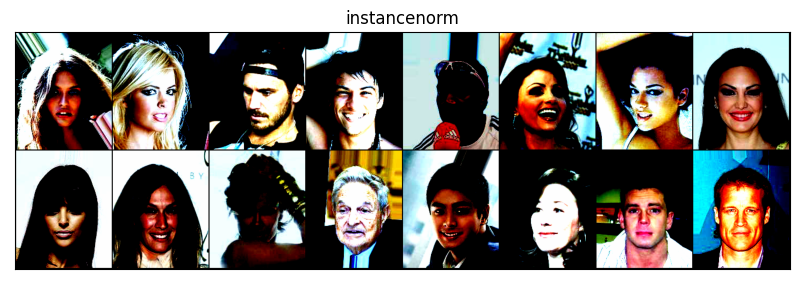

In [24]:
import torchvision.transforms.functional as F
from timeit import timeit
from torchvision.utils import make_grid
plt.rcParams["savefig.bbox"] = 'tight'
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
torch.manual_seed(10)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize=(10,5),ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torch.clamp(img, min=0, max=0.999)
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


modules = {'groupmap':gm, 'groupnorm':gn, 'layernorm':ln, 'instancenorm':inn}
for x, _ in dataloader:
    x=x.to(device)
    #show(make_grid(x)); plt.title('original')
    for key in ['instancenorm']:#modules:
        %timeit -n 100 test = modules[key](x)
        out = modules[key](x)
        
        show(make_grid(out)); plt.title(key)
    
    break